<center>
    <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">
    <h1> INF285 - Computación Científica </h1>
    <h2> Least Squares </h2>
    <h2> <a href="#acknowledgements"> [S]cientific [C]omputing [T]eam </a> </h2>
    <h2> Version: 1.35</h2>
</center>

<div id='toc' />

## Table of Contents
* [Introduction](#intro)
* [QR Factorization](#qr)
    * [Do we really have _truly_ unitary vectors?](#DoWeReallyHaveUnitaryVectors)
    * [Examples of QR: Classic vs Modified Gram-Schmidt](#ex)
* [Overdetermined Linear System of Equations](#over)
    * [Initial Example](#initialExample)
* [Examples of models](#sm)
* [Acknowledgements](#acknowledgements)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as spla
%matplotlib inline
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets
from sklearn import datasets
import ipywidgets as widgets
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
M=8
from ipywidgets import interact
from colorama import Fore, Back, Style
# https://pypi.org/project/colorama/
# Fore: BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE, RESET.
# Back: BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE, RESET.
# Style: DIM, NORMAL, BRIGHT, RESET_ALL
textBold = lambda x: Style.BRIGHT+x+Style.RESET_ALL
textBoldH = lambda x: Style.BRIGHT+Back.YELLOW+x+Style.RESET_ALL

<div id='intro' />

## Introduction
[Back to TOC](#toc)

We have learned about square linear system of equations. 
However, how can we solve a non-square linear system of equations? i.e. when we have more equations than unknowns! Well, the traditional step will be to find a least squares approximation!

<div id='qr' />

# QR Factorization

## Gram-Schmidt Orthogonalization
[Back to TOC](#toc)

This algorithm orthonormalize a set of input vectors, returning an **orthonormal set** that spans the same vector space.
We will only consider now that the input set of vectors are **linearly independent**.

Let $A=[\mathbf{a}_1\, ...., \mathbf{a}_n]$ a matrix with linearly independent column vectors $\in\mathbb{R}^m$ and $n \le m$.

We know the following for the orthogonal set:

\begin{align*}
    \mathbf{q}_i^T\,\mathbf{q}_i & = \|\mathbf{q}_i\|_2^2= 1\\
    \mathbf{q}_i^T\,\mathbf{q}_j & = 0, \, \text{ for } i\neq j
\end{align*}

Then the **classic** Gram-Schmidt orthonormalization finds the $\mathbf{q}_i$ and $r_{ij}$ from the following set of equations and considering the previous constraints:
\begin{align*}
    \mathbf{a}_1 &= r_{11}\,\mathbf{q}_1\\
    r_{11} &= \|\mathbf{a}_1\|_2\\
    \mathbf{q}_1 &= \dfrac{\mathbf{a}_1}{r_{11}}\\
    \mathbf{a}_2 &= r_{12}\,\mathbf{q}_1+r_{22}\,\mathbf{q}_2\\
    r_{12} &= \mathbf{q}_1^T\,\mathbf{a}_2\\
    r_{22} &= \|\mathbf{a}_2-r_{12}\,\mathbf{q}_1\|_2\\
    \mathbf{q}_2 &= \dfrac{\mathbf{a}_2-r_{12}\,\mathbf{q}_1}{r_{22}}\\
    \vdots &=  \vdots\\
    \mathbf{a}_k &= \sum_{i=1}^k r_{i,k}\,\mathbf{q}_i\\
    r_{i,k} &= \mathbf{q}_i^T\,\mathbf{a}_k, \, \text{ for } i<j\\
    r_{k,k} &= \left\|\mathbf{a}_k-\sum_{i=1}^{k-1} r_{i,k}\,\mathbf{q}_i\right\|_2\\
    \mathbf{q}_k &= \dfrac{\mathbf{a}_k-\sum_{i=1}^{k-1} r_{i,k}\,\mathbf{q}_i}{r_{k,k}}\\
    \vdots &=  \vdots\\
    \mathbf{a}_n &= \sum_{i=1}^n r_{in}\,\mathbf{q}_i\\
    r_{in} &= \mathbf{q}_i^T\,\mathbf{a}_n, \, \text{ for } i<n\\
    r_{nn} &= \left\|\mathbf{a}_n-\sum_{i=1}^{n-1} r_{in}\,\mathbf{q}_i\right\|_2\\
    \mathbf{q}_n &= \dfrac{\mathbf{a}_n-\sum_{i=1}^{n-1} r_{in}\,\mathbf{q}_i}{r_{nn}}
\end{align*}

Thus, we obtain the QR decomposition as follows:

\begin{equation}
                 \mathbf{A}_{m\times n} = \widehat{Q}_{m\times n}\widehat{R}_{n\times n},
\end{equation}
where $\widehat{Q}$ is a matrix of vectors $\mathbf{q}_{k}$, and $\widehat{R}$ is an upper-triangular matrix, with the coefficients $r_{i,k}$:

This is known as the **Reduced QR factorization**. 

**[IMPORTANT]** 
- What is then a **full** QR decomposition?
- What is then a **modified** Gram-Schmidt orthonormalization?


In [2]:
def QR(A, type_factorization = 'reduced', type_gram_schmidt='classic'):
    A.astype('float')
    m,n = A.shape # m: number of rows, n: number of columns.
    if type_factorization == 'reduced':
        Q = np.zeros((m,n))
        R = np.zeros((n,n))
    elif type_factorization == 'full':
        Q = np.zeros((m,m))
        R = np.zeros((m,n))
    for k in range(n):
        y = A[:,k]
        for i in range(k):
            if type_gram_schmidt == 'classic':
                R[i,k] = np.dot(Q[:,i],A[:,k])
            elif type_gram_schmidt == 'modified':
                R[i,k] = np.dot(Q[:,i],y)
            y=y-R[i,k]*Q[:,i]
        R[k,k] = np.linalg.norm(y)
        Q[:,k] = y/np.linalg.norm(R[k,k])
    # The following lines must be completed by you!
    #if type_factorization == 'full':    
        # (1) We need to add 0's to the R matrix so it is of the same shape as the matrix A, 
        # fortunately this was already done!
        # (2) We need to add orthogonal vectors to Q so it is square,
        # how do we do this?
    return Q,R

 ### First example:

In [3]:
A = np.array([[1,-4],[2,3],[2,2]])
Q_hat, R_hat = QR(A, type_factorization ='reduced', type_gram_schmidt='classic')
print(textBold('A:\n'),A)
print(textBold('Q_hat @ R_hat:\n'), Q_hat @ R_hat)
print(textBold('Q_hat:\n'), Q_hat)
print(textBold('R_hat:\n'), R_hat)
print(textBold('Q_hat.T @ Q_hat:\n'), Q_hat.T @ Q_hat)

A:
 [[ 1 -4]
 [ 2  3]
 [ 2  2]]
Q_hat @ R_hat:
 [[ 1. -4.]
 [ 2.  3.]
 [ 2.  2.]]
Q_hat:
 [[ 0.33333333 -0.93333333]
 [ 0.66666667  0.33333333]
 [ 0.66666667  0.13333333]]
R_hat:
 [[3. 2.]
 [0. 5.]]
Q_hat.T @ Q_hat:
 [[1.00000000e+00 2.28212511e-17]
 [2.28212511e-17 1.00000000e+00]]


<div id='DoWeReallyHaveUnitaryVectors' />

## Do we really have _truly_ unitary vectors?

[Back to TOC](#toc)

This is an example that shows that unitary vectors are not truly unitary in _double precision_!
For instance, in this case we define the vector $\mathbf{v}=[1,\delta]$, and we then make it unitary, which should result in $\mathbf{w}=\dfrac{\mathbf{v}}{\|\mathbf{v}\|}=\left[\dfrac{1}{\sqrt{1+\delta^2}},\dfrac{\delta}{\sqrt{1+\delta^2}}\right]$.
This is indeed true for _not too small_ values of $\delta$, however if $\delta^2<\epsilon_{\text{mach}}$, then the resulting vector $\mathbf{w}$ will be equal to $\mathbf{v}$.

In [4]:
def show_unitary_vector(n=0):
    # Small value 'delta'.
    delta = np.power(10.,n)
    
    print(textBold('delta=10^n= \t\t:'),delta)
    
    v=np.array([1,delta])
    print(textBold('Vector v\t\t:'),v)

    w=v/np.linalg.norm(v)
    
    print(textBold('Vector w=v/||v||\t:'),w)
    
    print(textBold('Vector v-w=\t\t:'),v-w)

    #print('Thus, they are the same for small values of d!!\nThis means that w is not truly unitary!')
    print(textBoldH('Are they different for all values of $\delta=10^{n}$?'))

interact(show_unitary_vector,n=(-20,20,1))

interactive(children=(IntSlider(value=0, description='n', max=20, min=-20), Output()), _dom_classes=('widget-i…

<function __main__.show_unitary_vector(n=0)>

<div id='ex' />

## Examples of QR: Classic vs Modified Gram-Schmidt

[Back to TOC](#toc)

In [5]:
# Fore: BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE, RESET.
# Back: BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE, RESET.
# Style: DIM, NORMAL, BRIGHT, RESET_ALL
textQRClassic = lambda x: Style.BRIGHT+Fore.RED+x+Style.RESET_ALL
textQRModified = lambda x: Style.BRIGHT+Fore.BLUE+x+Style.RESET_ALL
textAnswer = lambda x: Back.BLACK+Fore.CYAN+x+Style.RESET_ALL

In [6]:
# Example 4.16 from textbook.
d = 1e-10
A = np.array([[1,1,1],[d,0,0],[0,d,0],[0,0,d]])
print(textBold('A: \n'), A)

Qc,Rc = QR(A, type_gram_schmidt = 'classic')
Qm,Rm = QR(A, type_gram_schmidt = 'modified')

################################
print(textBoldH('\n What are the Q\'s?'))
print(textQRClassic('Qc: \n'), Qc)
print(textQRModified('Qm: \n'), Qm)

################################
print(textBoldH('\n Are truly orthogonal the q_i\'s?'))
print(textQRClassic('Qc.T*Qc: \n'),np.dot(Qc.T,Qc))
print(textQRClassic('||Qc.T*Qc-I_3||: '),np.linalg.norm(np.dot(Qc.T,Qc)-np.eye(3))) # Warning: We are just using the transpose since the matrices are real!
print(textAnswer('Not really, since q2^T*q3 \\neq 0.'))

print(textQRModified('\n Qm.T*Qm: \n'),np.dot(Qm.T,Qm))
print(np.linalg.norm(np.dot(Qm.T,Qm)-np.eye(3)))
print(textQRModified('||Qm.T*Qm-I_3||: '),np.linalg.norm(np.dot(Qm.T,Qm)-np.eye(3)))
print(textAnswer('This looks much better!'))

################################
print(textBoldH('\n Do we recover A with each algorithm?'))
print(textQRClassic('A-Qc*Rc: \n'),A-np.dot(Qc,Rc))
print(textQRClassic('||A-Qc*Rc||: '),np.linalg.norm(A-np.dot(Qc,Rc)))
print(textAnswer('Yes!'))

print(textQRModified('\n A-Qm*Rm: \n'),A-np.dot(Qm,Rm))
print(textQRModified('||A-Qm*Rm||: '),np.linalg.norm(A-np.dot(Qm,Rm)))
print(textAnswer('Yes!'))


A: 
 [[1.e+00 1.e+00 1.e+00]
 [1.e-10 0.e+00 0.e+00]
 [0.e+00 1.e-10 0.e+00]
 [0.e+00 0.e+00 1.e-10]]

 What are the Q's?
Qc: 
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e-10 -7.07106781e-01 -7.07106781e-01]
 [ 0.00000000e+00  7.07106781e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  7.07106781e-01]]
Qm: 
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e-10 -7.07106781e-01 -4.08248290e-01]
 [ 0.00000000e+00  7.07106781e-01 -4.08248290e-01]
 [ 0.00000000e+00  0.00000000e+00  8.16496581e-01]]

 Are truly orthogonal the q_i's?
Qc.T*Qc: 
 [[ 1.00000000e+00 -7.07106781e-11 -7.07106781e-11]
 [-7.07106781e-11  1.00000000e+00  5.00000000e-01]
 [-7.07106781e-11  5.00000000e-01  1.00000000e+00]]
||Qc.T*Qc-I_3||:  0.7071067811865477
Not really, since q2^T*q3 \neq 0.

 Qm.T*Qm: 
 [[ 1.00000000e+00 -7.07106781e-11 -4.08248290e-11]
 [-7.07106781e-11  1.00000000e+00 -1.54826171e-16]
 [-4.08248290e-11 -1.54826171e-16  1.00000000e+00]]
1.1547005383855976e

<div id='over' />

# Overdetermined Linear Systems of Equations
[Back to TOC](#toc)

There is cases where the number of equations is greater than variables. Many times, those systems don't have an exact solution (inconsistent system). Then, in this case we needs an approximation closest to the data. Based in orthogonality, the shortest distance from a point to plane. The orthogonal distance represents the error which would be minimum.

\begin{equation} 
                 \mathbf{b} - A\,\overline{\mathbf{x}} = \mathbf{r}\\
                 \mathbf{b} - A\,\overline{\mathbf{x}} \perp \{A\,\mathbf{x}\, |\, \mathbf{x} \in \mathbb{R}^m\}
\end{equation}

The idea is that $\mathbf{r}$ would be closest to zero. We need to apply orthogonality to find the vector that satisfied this condition.

\begin{align*} 
                 (A\,\mathbf{x})^*\,(\mathbf{b}-A\,\overline{\mathbf{x}})&=0, \hspace{1cm} \text{for all } \mathbf{x} \in \mathbb{R}^n\\
                 \mathbf{x}^*\, A^*\,(\mathbf{b}-A\,\overline{\mathbf{x}})&=0, \hspace{1cm} \text{for all } \mathbf{x} \in \mathbb{R}^n\\
                 A^*\,(\mathbf{b}-A\,\overline{\mathbf{x}})&=\mathbf{0} \\
                 A^*\,A\,\overline{\mathbf{x}}&= A^*\,\mathbf{b} \\
\end{align*}

This last equation gives us a new square $n\times n$ matrix, which let us resolve the equation system.
This linear system of equations is known as the **Normal Equations**.

<div id='initialExample' />

### Initial example:
[Back to TOC](#toc)

In this example we will approximate $m$ points considering a linear relationship.
This means that we will have the data points $(x_i,y_i)$ for $i\in\{1,2,\dots,m\}$ and consider the relationshop $y=a_0+a_1\,b$.
The error that will be added follows a normal distribution.

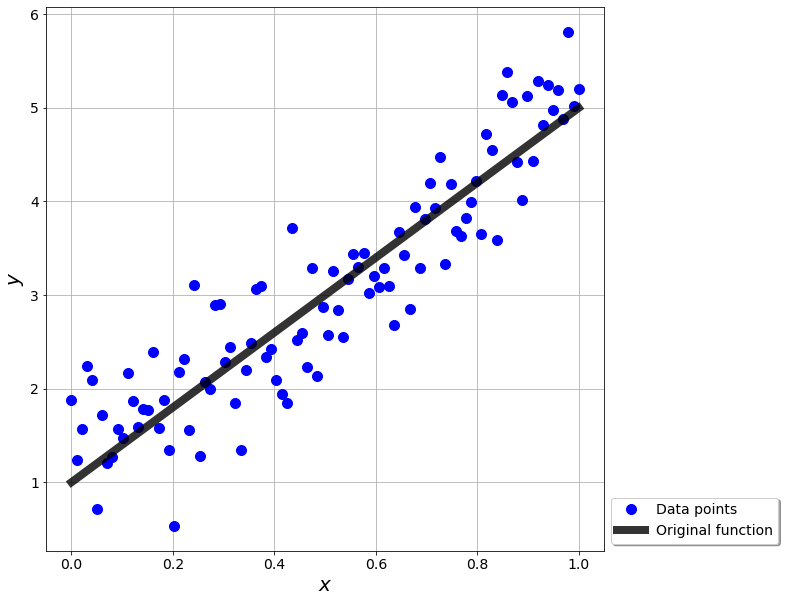

In [7]:
# Number of points to be used
m = 100
# Relationship considered
fv = np.vectorize(lambda x, a0, a1: a0+a1*x)
# Coefficients considered
a0, a1 = 1, 4

# Error:
np.random.seed(0)
# Standard deviation for the error
sigma = 5e-1
# Error to be added
e = np.random.normal(0,sigma,m)

# Generating data points
x = np.linspace(0,1,m)
y = fv(x,a0,a1)+e
# Challenging question: What if all the xi are the same?
# This means that considering the following definition for x, for instance:
# x = np.linspace(0,1,m)*0+0.5

# Plotting the data
plt.figure(figsize=(10,10))
plt.plot(x,y,'b.',markersize=20, label='Data points')
plt.plot(x,fv(x,a0,a1),'k-',linewidth=8,alpha=0.8, label='Original function')
plt.legend(loc='lower left', ncol=1, fancybox=True, shadow=True, numpoints=1, bbox_to_anchor=(1,0))
plt.grid(True)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

In [8]:
# Build the data matrix
A = np.ones((m,2))
A[:,1] = x
# Setting up the right hand side
b = y

# Building and solving the normal equations
# A^T A x_bar = A^T b
x_bar = np.linalg.solve(A.T @ A, A.T @ b)
# Showing solution found, please compare with a0 and a1 defined previously. 
# Are the the same? Are they close? What does it happen with them if we increase "m" and decrease "sigma"?
print(x_bar)

[1.10423572 3.85133657]


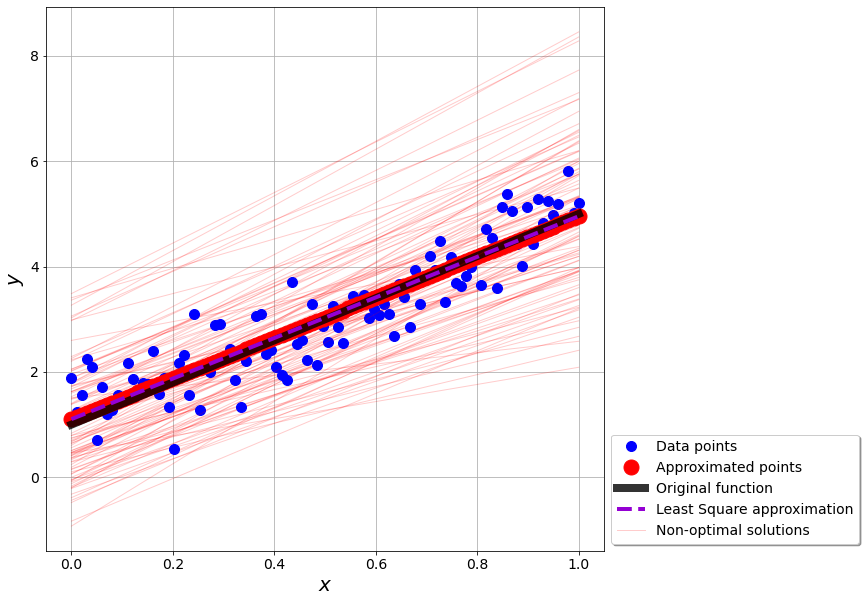

In [9]:
# Showing the comparison between the "original function" and the "least-squared reconstructed approximation".
# We added in red a "sample" of possible functions.
# Notice that the colors used follow the description included in the classnotes.
# This means to consider the following analogy:
# blue: data points, this correspond to the right-hand-side vector "b".
# red: this correspond to the sub-space generated by Ax, i.e. the span of the columns of A.
# violet: This correspond to the least-square solution found.
plt.figure(figsize=(10,10))
for i in range(100):
    plt.plot(x,fv(x,x_bar[0]+np.random.normal(0,1),x_bar[1]+np.random.normal(0,1)),'r-',linewidth=1,alpha=0.2)
plt.plot(x,y,'b.',markersize=20, label='Data points')
plt.plot(x,fv(x,x_bar[0],x_bar[1]),'r.', markersize=30, label='Approximated points')
plt.plot(x,fv(x,a0,a1),'k-',linewidth=8,alpha=0.8, label='Original function')
plt.plot(x,fv(x,x_bar[0],x_bar[1]),'--',color='darkviolet',linewidth=4, label='Least Square approximation')
plt.plot(x,fv(x,x_bar[0]+np.random.normal(0,1),x_bar[1]+np.random.normal(0,1)),'r-',linewidth=1,alpha=0.2, label='Non-optimal solutions')
plt.grid(True)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend(loc='lower left', ncol=1, fancybox=True, shadow=True, numpoints=1, bbox_to_anchor=(1,0))
plt.show()

In [10]:
# Computing the quadratic error ||r||_2^2 of the least-square solution
print('Quadratic error of LS solution: ',np.linalg.norm(b-A @ x_bar)**2)
# Computing the quadratic error ||r||_2^2 of the "original" parameters
x_no_bar = np.array([a0,a1])
print('Quadratic error of original parameters: ',np.linalg.norm(b-A @ x_no_bar)**2)

# Verifying if the columns of A are orthogonal to the "residual" vector rLS=b-A x_bar.
print('Inner product of rLS and each column of A: ',A.T @ (b-A @ x_bar))

# Computing the ortogonality condition against the "original" a0 y a1, i.e. rOR=b-A x_no_bar
print('Inner product of rOR and each column of A: ',A.T @ (b-A @ x_no_bar))

Quadratic error of LS solution:  25.207771336715297
Quadratic error of original parameters:  25.48509044842761
Inner product of rLS and each column of A:  [-7.28306304e-14 -4.32986980e-15]
Inner product of rOR and each column of A:  [2.99040078 0.23131094]


<div id='sm' />

# Examples of models
[Back to TOC](#toc)

In [11]:
def least_squares(A,b):
    Q,R = QR(A,type_gram_schmidt='modified')
    return spla.solve_triangular(R,np.dot(Q.T,b))

def solve_model(M):
    A=M['A']
    b=M['b']
    M['x_bar']=least_squares(A,b)
    return M

def create_model(data, type_model='linear'):
    if type_model == 'linear': # f(x)=a0+a1*x
        A = np.ones((data.shape[0],2))
        A[:,1] = data[:,0]
        b = data[:,1]
    if type_model == 'parabollic': # f(x)=a0+a1*x+a_2*x^2
        A = np.ones((data.shape[0],3))
        A[:,1] = data[:,0]
        A[:,2] = data[:,0]**2
        b = data[:,1]
    if type_model == 'exponential': #f(x)=a0 \exp(a1*x) = \exp(\log(a0)+a1*x) -> log(f(x))=log(a0)+a1*x = A0+a1+x (it is linear now!)
        A = np.ones((data.shape[0],2))
        A[:,1] = data[:,0]
        b = np.log(data[:,1])
    M = {'A':A,
         'b':b,
         'type_model':type_model}
    M=solve_model(M)
    return M

def evaluate_model(M,x):
    x_bar=M['x_bar']
    if M['type_model'] == 'linear':
        return x_bar[0] + x_bar[1]*x
    if M['type_model'] == 'parabollic':
        return x_bar[0] + x_bar[1]*x + x_bar[2]*x**2
    if M['type_model'] == 'exponential':
        return np.exp(x_bar[0]+x_bar[1]*x)

In [12]:
def generate_data(type_of_data='linear'):
    n=40
    np.random.seed(0)
    x = np.linspace(0,10,n)
    y = np.random.rand(n)
    x = np.concatenate((x,x,y),axis=0)
    n = 3*n
    if type_of_data=='linear':
        y = x+0.1*np.random.normal(0,1,n)+1.5
    elif type_of_data=='parabollic':
        y = 4*x**2+0.1*x*np.random.normal(0,1,n)+1.5
    elif type_of_data=='exponential':
        y = np.exp(x+0.1*np.random.normal(0,1,n)+1.5)
    elif type_of_data=='sinusoidal':
        y = np.sin(2*np.pi*x/10)+0.1*np.random.normal(0,1,n)+1.5
    elif type_of_data=='random':
        y = 0.1*np.random.normal(0,1,n)+1.5
    elif type_of_data=='boston house-prices':
        x,y=datasets.load_boston(return_X_y=True)
        x=x[:,5]
    elif type_of_data=='diabetes':
        x,y=datasets.load_diabetes(return_X_y=True)
        x=x[:,2]
    data = np.stack((x, y)).T
    return data

In [13]:
def looking_at_data(type_of_data='diabetes'):
    data=generate_data(type_of_data)
    Ml = create_model(data, type_model='linear')
    Mp = create_model(data, type_model='parabollic')
    Me = create_model(data, type_model='exponential')
    xx=np.linspace(np.min(data[:,0])-0.1,np.max(data[:,0])+0.1,1000)
    yyl=evaluate_model(Ml,xx)
    yyp=evaluate_model(Mp,xx)
    yye=evaluate_model(Me,xx)
    
    error_l=data[:,1]-evaluate_model(Ml,data[:,0])
    error_p=data[:,1]-evaluate_model(Mp,data[:,0])
    error_e=data[:,1]-evaluate_model(Me,data[:,0])
    
    plt.figure(figsize=(2*M,M))
    
    plt.subplot(1, 2, 1)
    plt.plot(xx,yyl,'k-',linewidth=5,label='linear model')
    plt.plot(xx,yyp,'y-',linewidth=20,label='parabollic model',alpha=0.4)
    plt.plot(xx,yye,'g-',linewidth=5,label='exponential model')
    plt.plot(data[:,0],data[:,1],'.b',markersize=20,label='original data',alpha=0.3)
    plt.grid(True)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.legend(loc='best')
    #plt.ylim(0,10)
    
    plt.subplot(1, 2, 2)
    plt.title('What does this histogram tell us?')
    three_errors=np.vstack((error_l, error_p, error_e)).T
    plt.hist(three_errors, bins=20,
             label=['linear','parabollic','exponential'],
             color=['k','y','g'], alpha=0.5)
    plt.legend(loc='best')
    plt.grid(True)
    
    plt.show()
widgets.interact(looking_at_data,type_of_data=['linear','parabollic','exponential','sinusoidal','random','boston house-prices','diabetes'])

interactive(children=(Dropdown(description='type_of_data', index=6, options=('linear', 'parabollic', 'exponent…

<function __main__.looking_at_data(type_of_data='diabetes')>

## References
[Back to TOC](#toc)

### Numpy Least Squares
http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html

### Numpy QR Factorization
http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.qr.html

### Scikit Learn Datasets
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets

### Colorama
https://pypi.org/project/colorama/

<div id='acknowledgements' />

# Acknowledgements
[Back to TOC](#toc)
* _Material created by professor Claudio Torres_ (`ctorres@inf.utfsm.cl`) _and assistans: Laura Bermeo, Alvaro Salinas, Axel Símonsen and Martín Villanueva. DI UTFSM. April 2016._
* _Material updated by professor Claudio Torres_ (`ctorres@inf.utfsm.cl`) DI UTFSM. June 2017.
* _Material updated by professor Claudio Torres_ (`ctorres@inf.utfsm.cl`) DI UTFSM. July 2019.
* _Material updated by professor Claudio Torres_ (`ctorres@inf.utfsm.cl`) DI UTFSM. August 2019.
* _Update July 2020 - v1.27 - C.Torres_ : Fixing formatting issues.
* _Update June 2021 - v1.28 - C.Torres_ : Re-ordering notebook and adding TOC link.
* _Update June 2021 - v1.29 - C.Torres_ : Adding "initial example" in the section "Overdetermined Linear Systems of Equations".
* _Update June 2021 - v1.30 - C.Torres_ : Adding colors to the numerical example of QR factorization.
* _Update June 2021 - v1.31 - C.Torres_ : Adding more colors and an example to show that unitary vectors in double precision may not be truly unitary! And answers in the QR example.
* _Update June 2021 - v1.32 - C.Torres_ : Update of QR implementation, using 'm' and 'n', and including sub-index 'k' to match the 'LaTex' explanation and classnotes.
* _Update November 2021 - v1.33 - C.Torres_ : Updating text, adding a widget for unitary vectors.
* _Update November 2021 - v1.34 - C.Torres_ : Updating TOC.
* _Update May 2022 - v1.35 - C.Torres_ : Adding legend to the plots.
